## Davide Maniscalco, 1212063

#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE, we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

11493376/11490434 [==============================] - 1s 0us/step


##Exercise 6.1: Variational Autoencoder and the reparameterization trick
The reparameterization trick is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

**To complete: complete the code defining the Sampling layer that implements the reparameterization trick**

**Hint: to generate a random value from a normal distribution keras provides the [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.**

**In addition to that, explain why in the reparameterization formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$.**


In [0]:
class Sampling(tf.keras.layers.Layer):

  def call(self, inputs):
    z_mean, z_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
    return z_mean + tf.exp(z_var) * epsilon

It makes sense to use $\exp(z_{\sigma})$ beacuse in this way we won't have to compute a logarithm when computing kl_loss.

##Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW4), and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the exploration of the latent space, we will stick on a latent space of size $2$ (that is, the dimension of $z$ should be $2$).

**To complete: complete the code defining a deep encoder and the Dense layers that model $z_{\mu}$ and $z_\sigma$. Justify in this cell your choice for what concerns the layers sizes and the activation functions** 

Since it is an autoencoder, the last layer should map every point into a different one: for this reason sigmoid was chosen (**maybe** also tanh would have been good). For the hidden layers, ReLu was chosen for its solidity (e.g.: no easy saturation). Layer sizes were chosen big, in order to have more parameters, while the last one isn't very big in order to avoid an abrupt "jump" to the two sampling nodes. The analysis of point 5 will examine other choices for the sizes.

In [37]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(729,activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(100,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    #z_mean is a vector of two elems, and z_var also 
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_97 (Dense)                (None, 729)          572265      input_23[0][0]                   
__________________________________________________________________________________________________
dense_98 (Dense)                (None, 676)          493480      dense_97[0][0]                   
__________________________________________________________________________________________________
dense_99 (Dense)                (None, 100)          67700       dense_98[0][0]                   
____________________________________________________________________________________________

##Exercise 6.3: Decoder
Then we have to define the decoder part. It has in input $z$ and returns its "decoding". Its topology will have a ``mirror'' shape w.r.t. the encoder. 

**To complete: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes and the activation functions (in particular for what concerns the last layer)**

All the hyperparameters were chosen for mirroring the encoder.

In [38]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(100,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(729,activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_102 (Dense)            (None, 100)               300       
_________________________________________________________________
dense_103 (Dense)            (None, 676)               68276     
_________________________________________________________________
dense_104 (Dense)            (None, 729)               493533    
_________________________________________________________________
dense_105 (Dense)            (None, 784)               572320    
Total params: 1,134,429
Trainable params: 1,134,429
Non-trainable params: 0
_________________________________________________________________


##Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**To complete: implement the reconstruction loss and KL-loss (look at the VAE paper in Moodle)**

In [0]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = 784*tf.reduce_mean(keras.losses.binary_crossentropy(data,reconstruction))

            kl_loss = -0.5*(1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(kl_loss)
        
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer

In [39]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 2s 4ms/step - loss: 189.3816 - reconstruction_loss: 187.8619 - kl_loss: 1.5197
Epoch 2/30
391/391 [==============================] - 1s 4ms/step - loss: 159.7106 - reconstruction_loss: 157.9142 - kl_loss: 1.7964
Epoch 3/30
391/391 [==============================] - 1s 4ms/step - loss: 151.3781 - reconstruction_loss: 149.4744 - kl_loss: 1.9037
Epoch 4/30
391/391 [==============================] - 1s 4ms/step - loss: 146.4231 - reconstruction_loss: 144.4566 - kl_loss: 1.9664
Epoch 5/30
391/391 [==============================] - 1s 4ms/step - loss: 144.1082 - reconstruction_loss: 142.1168 - kl_loss: 1.9914
Epoch 6/30
391/391 [==============================] - 1s 4ms/step - loss: 142.3208 - reconstruction_loss: 140.2944 - kl_loss: 2.0264
Epoch 7/30
391/391 [==============================] - 1s 4ms/step - loss: 140.6482 - reconstruction_loss: 138.5941 - kl_loss: 2.0541
Epoch 8/30
391/391 [==============================] - 1s 4ms/step - l

##Exercise 6.5: Model Analysis
We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


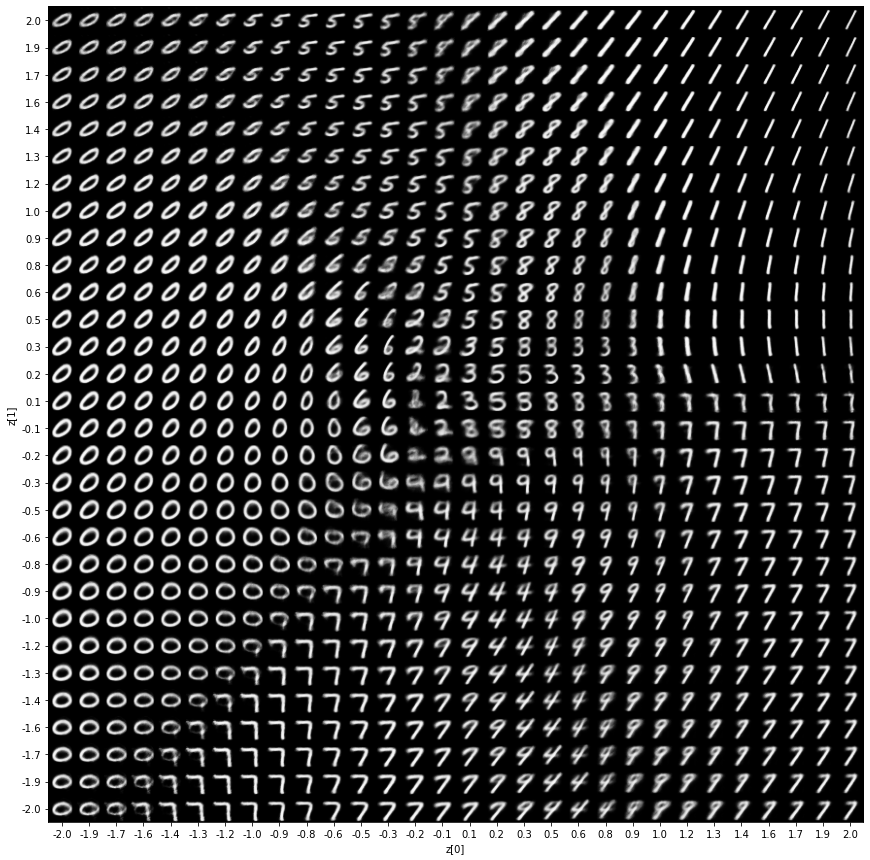

In [40]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#To complete: explore with different "scale"
# just change the scale parameter in input

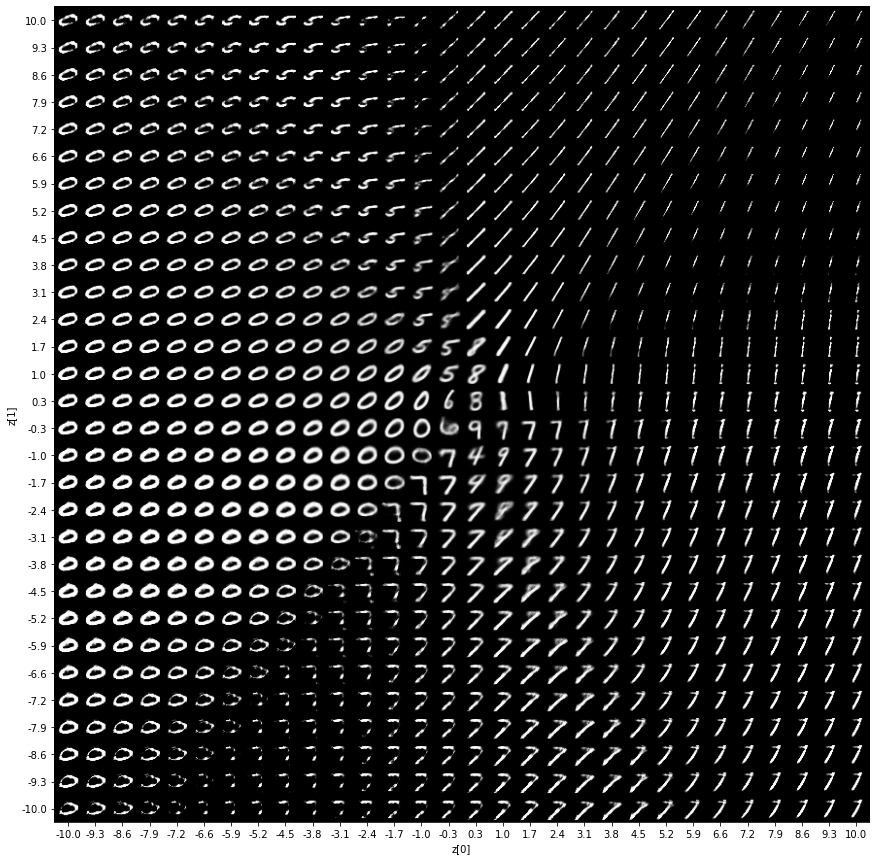

In [41]:
plot_latent(encoder, decoder, 10.0, 30) 

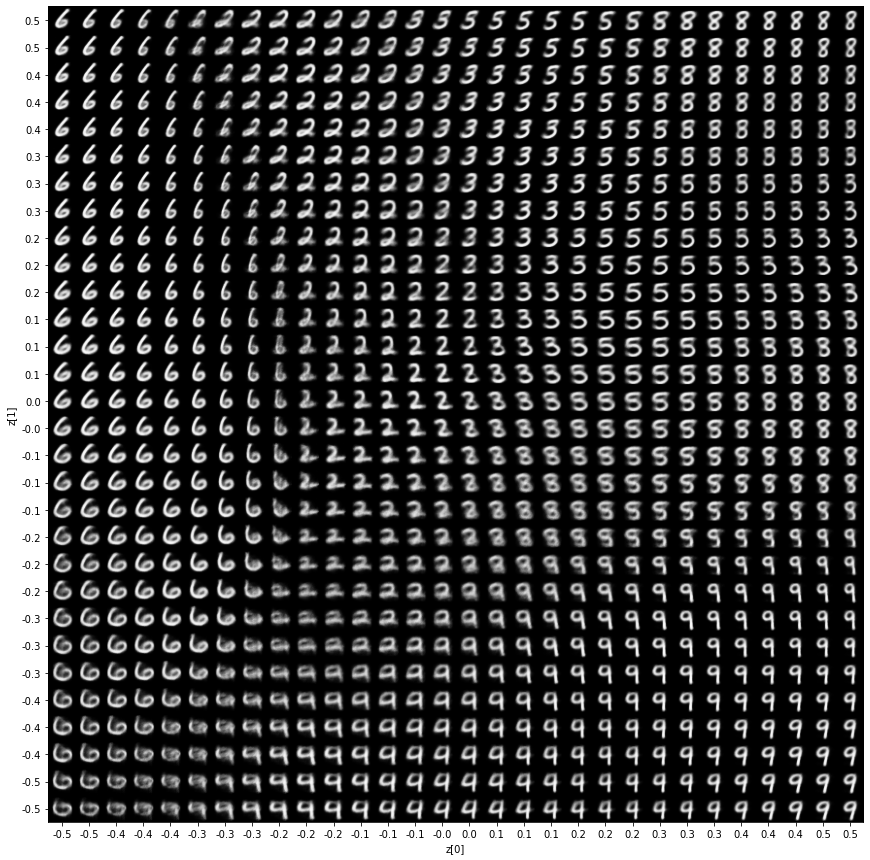

In [42]:
plot_latent(encoder, decoder, 0.5, 30) 

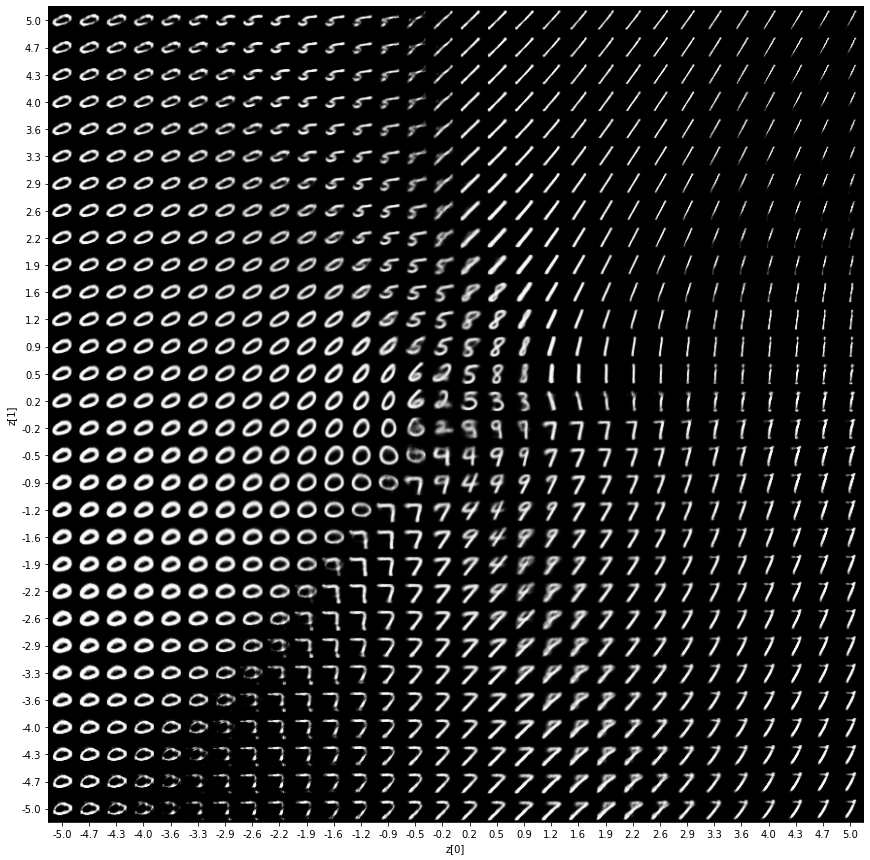

In [43]:
plot_latent(encoder, decoder, 5.0, 30) 

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

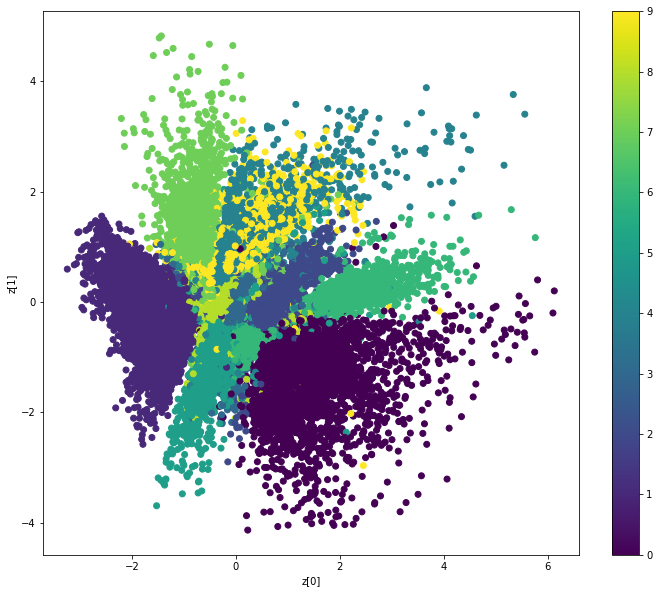

In [0]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

At different scales, it is possible to see the reconstruction of some numbers, some ones well performed and some others less. In the last plot one should observe the separation of the points of the same color: this unfortunately doesn't happen for the yellow points in the center.

**To complete: Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

In [0]:
# ONLY ONE LAYER
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256,activation='relu')(encoder_inputs)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(256,activation='relu')(latent_inputs)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

# plot
plot_latent(encoder, decoder, 0.5, 30) 
plot_latent(encoder, decoder, 2.0, 30)
plot_latent(encoder, decoder, 10.0, 30)

Output hidden; open in https://colab.research.google.com to view.

Results here are clearly bad, one layer is not enough

In [0]:
# LESS "DESCENDING" LAYER SIZES
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(729,activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(625,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(625,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(729,activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

# plot
plot_latent(encoder, decoder, 0.5, 30) 
plot_latent(encoder, decoder, 2.0, 30)
plot_latent(encoder, decoder, 10.0, 30)

Output hidden; open in https://colab.research.google.com to view.

These results are a bit better than the first ones; probably the high number of parameters plays a role in this.

In [11]:
# INITIAL ABRUPT DESCEND OF LAYER SIZES
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(729,activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(81,activation='relu')(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(81,activation='relu')(x)
x = tf.keras.layers.Dense(729,activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

# plot
plot_latent(encoder, decoder, 0.5, 30) 
plot_latent(encoder, decoder, 2.0, 30)
plot_latent(encoder, decoder, 10.0, 30)

Output hidden; open in https://colab.research.google.com to view.

This is the worst results achieved: too few trainable parameters

In [45]:
# MORE EPOCHS,MANY PARAMETERS
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(729,activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(49,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(49,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(729,activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=50, batch_size=128)

# plot
plot_latent(encoder, decoder, 0.5, 50) 
plot_latent(encoder, decoder, 2.0, 50)
plot_latent(encoder, decoder, 5.0, 50)
plot_latent(encoder, decoder, 10.0,50)

Output hidden; open in https://colab.research.google.com to view.

Looking at the loss, this is the best model found: 30 epochs weren't enough.

In [29]:
# 50 EPOCHS, MANY BIG LAYERS
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(729,activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(625,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(625,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(729,activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=50, batch_size=128)

# plot
plot_latent(encoder, decoder, 0.5, 50) 
plot_latent(encoder, decoder, 2.0, 50)
plot_latent(encoder, decoder, 5.0, 50)
plot_latent(encoder, decoder, 10.0,50)

Output hidden; open in https://colab.research.google.com to view.

Looking at the loss, the performance is a bit worse than before: the last layer shouldn't big so big as the first two.

In [49]:
# 50 EPOCHS, FOUR HIDDEN LAYERS
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(729,activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(625,activation='relu')(x)
x = tf.keras.layers.Dense(49,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)    
z_var =  tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(49,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(625,activation='relu')(x)
x = tf.keras.layers.Dense(676,activation='relu')(x)
x = tf.keras.layers.Dense(729,activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=50, batch_size=128)

# plot
plot_latent(encoder, decoder, 0.5, 50) 
plot_latent(encoder, decoder, 2.0, 50)
plot_latent(encoder, decoder, 5.0, 50)
plot_latent(encoder, decoder, 10.0,50)

Output hidden; open in https://colab.research.google.com to view.

The performance isn't better than the best one found: three layers provide enough complexity, the fourth isn't needed,